# Demo 说明

1. <font size=4> ***本文档展示了如何用 `utils/` 中的函数进行建模。使用前请按照repo里面的 `/modeling/requirements.txt`安装相关包。安装方法请见 `/modeling/README.md`  *** </font>
2. <font size=4> ***本文档所展示的代码仅为示例，请根据建模时的具体情况做相应的调整。***</font> <font size=6 color=red> ***请勿直接照搬!*** </font>


# Import packages/modules

导入需要用的module和package， 配置Python环境encoding

In [1]:
%matplotlib inline

import os
import sys
import json
import logging
import warnings

import pandas as pd
import numpy as np
from jinja2 import Template

import utils.feature_selection as fs
import utils.summary_statistics as ss
import utils.metrics as mt
import utils.misc_utils as mu
import utils.plotting as pl
from utils.data_io_utils import *

# 在python环境中逐条执行代码时，需要将python执行环境encoding更改为utf-8。
stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

warnings.filterwarnings('ignore')

/Users/xiangyu/ENV/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/xiangyu/ENV/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/xiangyu/ENV/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/xiangyu/ENV/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are privat

# 设置数据路径

In [2]:
DATA_PATH = "/Users/xiangyu/Documents/Seafile/分析文件/modeling/个贷/YZF/01_data/"
RESULT_PATH = "/Users/xiangyu/Documents/Seafile/分析文件/modeling/个贷/YZF/02_result/"


# 整理字典

把秒鉴下载下来的指标列表字典进行重命名整理方便代码使用。或者监测是否有足够需要的字典列名。缺少的会`print`出来。

In [3]:
raw_var_dict = pd.read_excel(os.path.join(DATA_PATH, '外部数据变量字典20171024-翼支付.xlsx'), \
                         encoding='utf-8', sheetname='变量字典')

var_dict = mu.clean_var_dict(raw_var_dict)
var_dict.to_excel(os.path.join(DATA_PATH, '建模代码可用变量字典.xlsx'), index=False, encoding='utf-8')

# 数据录入

以下只是数据录入的样例，各数据录入依数据具体情况而定。

In [14]:
data = pd.read_excel(os.path.join(DATA_PATH, '返回数据-x.xlsx'), encoding='gbk')
data.head()

,applyid,appmonth,yzf_2,yzf_3,yzf_4,yzf_5,yzf_6,yzf_7,yzf_8,yzf_9,yzf_10,licaidate,sex,shimingdate,Y
0,1,2017-01,4.0,0.000000,200.059998,0.0,99.739998,400.119995,0.00,12.0,0.0,2015-11-12 08:05:16,M,2015-11-12 07:58:47,1
1,2,2017-02,2.0,0.000000,28.070000,0.0,0.020000,28.070000,0.00,43.0,0.0,-9999999,M,2016-09-02 01:31:42,1
2,3,2016-12,2.0,1.000000,0.000000,0.0,1.000000,0.000000,1.00,0.0,0.0,2015-08-24 17:12:34,M,2015-08-24 17:12:34,1
3,4,2016-12,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,2015-09-08 03:14:06,F,2015-09-08 03:14:06,1
4,5,2017-03,32.0,38.920002,362.581848,3.0,538.057007,19579.419922,28.34,79.0,3.0,2016-11-13 13:33:54,M,2016-11-13 13:30:02,1


** <font size=4>重要：将数据的index设置为 applyid或者unique identifier </font>**

In [15]:
data.index = data.applyid

In [17]:
X = data.drop(['applyid', 'Y', 'appmonth'], 1)
X.head()

,yzf_2,yzf_3,yzf_4,yzf_5,yzf_6,yzf_7,yzf_8,yzf_9,yzf_10,licaidate,sex,shimingdate
applyid,,,,,,,,,,,,
1,4.0,0.000000,200.059998,0.0,99.739998,400.119995,0.00,12.0,0.0,2015-11-12 08:05:16,M,2015-11-12 07:58:47
2,2.0,0.000000,28.070000,0.0,0.020000,28.070000,0.00,43.0,0.0,-9999999,M,2016-09-02 01:31:42
3,2.0,1.000000,0.000000,0.0,1.000000,0.000000,1.00,0.0,0.0,2015-08-24 17:12:34,M,2015-08-24 17:12:34
4,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,2015-09-08 03:14:06,F,2015-09-08 03:14:06
5,32.0,38.920002,362.581848,3.0,538.057007,19579.419922,28.34,79.0,3.0,2016-11-13 13:33:54,M,2016-11-13 13:30:02


In [18]:
y = data.Y
y.head()

applyid
1    1
2    1
3    1
4    1
5    1
Name: Y, dtype: int64

In [19]:
var_dict = pd.read_excel(os.path.join(DATA_PATH, '建模代码可用变量字典.xlsx'), encoding='utf-8')
var_dict.head()

,数据源,数据类型,变量类型,待确认,变量英文,中间层是否使用,JSON原始变量名称,线下变量英文,是否可以直接使用（不考虑业务含义）,变量中文,变量解释,取值解释,更新时间
0,翼支付,varchar,原始变量,NaN,appmonth,NaN,NaN,NaN,NaN,提取时点,NaN,NaN,NaN
1,翼支付,integer,原始变量,NaN,yzf_2,NaN,NaN,NaN,NaN,上三个自然月累计有消费天数,NaN,NaN,NaN
2,翼支付,integer,原始变量,NaN,yzf_3,NaN,NaN,NaN,NaN,上三个自然月营销参与平均金额,NaN,NaN,NaN
3,翼支付,integer,原始变量,NaN,yzf_4,NaN,NaN,NaN,NaN,上三个自然月提现到本人银行卡平均金额,NaN,NaN,NaN
4,翼支付,integer,原始变量,NaN,yzf_5,NaN,NaN,NaN,NaN,上三个自然月通信缴费天数,NaN,NaN,NaN


# 处理缺失值

处理缺失值的时候，发现-9999999是原始数据中已经标注的缺失值。

In [20]:
X = mu.process_missing(X, var_dict, known_missing={-9999999: -8887})

In [21]:
X.head()

,yzf_10,shimingdate,sex,yzf_5,yzf_4,yzf_7,yzf_6,licaidate,yzf_3,yzf_2,yzf_9,yzf_8
applyid,,,,,,,,,,,,
1,0.0,2015-11-12 07:58:47,M,0.0,200.059998,400.119995,99.739998,2015-11-12 08:05:16,0.000000,4.0,12.0,0.00
2,0.0,2016-09-02 01:31:42,M,0.0,28.070000,28.070000,0.020000,-8887,0.000000,2.0,43.0,0.00
3,0.0,2015-08-24 17:12:34,M,0.0,0.000000,0.000000,1.000000,2015-08-24 17:12:34,1.000000,2.0,0.0,1.00
4,0.0,2015-09-08 03:14:06,F,0.0,0.000000,0.000000,0.000000,2015-09-08 03:14:06,0.000000,1.0,0.0,0.00
5,3.0,2016-11-13 13:30:02,M,3.0,362.581848,19579.419922,538.057007,2016-11-13 13:33:54,38.920002,32.0,79.0,28.34


# 转换数据类型

In [22]:
X = mu.convert_right_data_type(X, var_dict)

# 整理清理好的数据并保存

至此，数据预处理已经完成，直接存成pickle可保留处理过的数据类型。 <font size=4> 保存前确保index为applyid或其他uniqe identifier </font>

In [ ]:
all_with_y = X.merge(data[['applicationdate', 'Y']], left_index=True, right_index=True)
all_with_y.loc[:, 'appmonth'] = all_with_y.applicationdate.apply(lambda x: str(x)[:7])

In [24]:
all_with_y.head()

,yzf_10,shimingdate,sex,yzf_5,yzf_4,yzf_7,yzf_6,licaidate,yzf_3,yzf_2,yzf_9,yzf_8,appmonth,Y
applyid,,,,,,,,,,,,,,
1,0,2015-11-12 07:58:47,M,0,200,400,99,2015-11-12 08:05:16,0,4,12,0,2017-01,1
2,0,2016-09-02 01:31:42,M,0,28,28,0,-8887,0,2,43,0,2017-02,1
3,0,2015-08-24 17:12:34,M,0,0,0,1,2015-08-24 17:12:34,1,2,0,1,2016-12,1
4,0,2015-09-08 03:14:06,F,0,0,0,0,2015-09-08 03:14:06,0,1,0,0,2016-12,1
5,3,2016-11-13 13:30:02,M,3,362,19579,538,2016-11-13 13:33:54,38,32,79,28,2017-03,1


In [26]:
save_data_to_pickle(all_with_y, DATA_PATH, 'all_with_y.pkl')

# 读入数据准备建模

In [28]:
all_with_y = load_data_from_pickle(DATA_PATH, 'all_with_y.pkl')
var_dict = pd.read_excel(os.path.join(DATA_PATH, '建模代码可用变量字典.xlsx'), encoding='utf-8')

In [ ]:
X = all_with_y.drop(['applicationdate', 'appmonth', 'Y'], 1)

# EDA

所有变量的exploratory data analysis, 所有变量不同类型的缺失占比，连续型变量的最小值，最大值，均值以及各percentile的值。分类型变量的最高频出现的前三种分类数量和占比。以及一些简单的过滤规则结果(如缺失率过高，数据variation约等于0等)

In [32]:
useless_vars=['shimingdate', 'licaidate']
ss.eda(X, var_dict, useless_vars=useless_vars, exempt_vars=[],\
       data_path=RESULT_PATH, save_label='all')

# 筛掉Summary excluded变量进行综合排序

In [33]:
summary = pd.read_excel(os.path.join(RESULT_PATH, 'all_variables_summary.xlsx'), encoding='utf-8')
kept = summary.loc[pd.isnull(summary.exclusion_reason), u'变量英文'].tolist()

In [34]:
X = all_with_y[kept]
y = all_with_y.Y

In [35]:
X.head()

,yzf_2,yzf_3,yzf_4,yzf_5,yzf_6,yzf_7,yzf_8,yzf_9,yzf_10,sex
applyid,,,,,,,,,,
1,4,0,200,0,99,400,0,12,0,M
2,2,0,28,0,0,28,0,43,0,M
3,2,1,0,0,1,0,1,0,0,M
4,1,0,0,0,0,0,0,0,0,F
5,32,38,362,3,538,19579,28,79,3,M


In [36]:
y.head()

applyid
1    1
2    1
3    1
4    1
5    1
Name: Y, dtype: int64

# 分Train，Test样本

如果样本量太小，决定不分train， test样本，则可以跳过这一步。

In [37]:
from sklearn.model_selection import train_test_split
train_apply, test_apply = train_test_split(data.applyid, test_size=0.30, random_state=42)

data.loc[:, 'sample_set'] = np.where(data.applyid.isin(train_apply), 'train', 'test')

In [38]:
data.head()

,applyid,appmonth,yzf_2,yzf_3,yzf_4,yzf_5,yzf_6,yzf_7,yzf_8,yzf_9,yzf_10,licaidate,sex,shimingdate,Y,sample_set
applyid,,,,,,,,,,,,,,,,
1,1,2017-01,4.0,0.000000,200.059998,0.0,99.739998,400.119995,0.00,12.0,0.0,2015-11-12 08:05:16,M,2015-11-12 07:58:47,1,train
2,2,2017-02,2.0,0.000000,28.070000,0.0,0.020000,28.070000,0.00,43.0,0.0,-9999999,M,2016-09-02 01:31:42,1,train
3,3,2016-12,2.0,1.000000,0.000000,0.0,1.000000,0.000000,1.00,0.0,0.0,2015-08-24 17:12:34,M,2015-08-24 17:12:34,1,test
4,4,2016-12,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,2015-09-08 03:14:06,F,2015-09-08 03:14:06,1,train
5,5,2017-03,32.0,38.920002,362.581848,3.0,538.057007,19579.419922,28.34,79.0,3.0,2016-11-13 13:33:54,M,2016-11-13 13:30:02,1,train


In [20]:
# data.to_excel(os.path.join(DATA_PATH, '返回数据-x.xlsx'), encoding='gbk')

In [39]:
X_train = X.loc[data.loc[data.sample_set=='train', 'applyid'].tolist(), :]
X_test = X.loc[data.loc[data.sample_set=='test', 'applyid'].tolist(), :]
y_train = y.loc[data.loc[data.sample_set=='train', 'applyid'].tolist()]
y_test = y.loc[data.loc[data.sample_set=='test', 'applyid'].tolist()]

# 各算法的overall_ranking

`IV` 是必会包含的, 输出中就有`WOE`表和整理好的相应的`rebin_spec`分箱字典。。其他算法如`random_forest`, `lasso`, `xgboost`可选。
当变量很多时，可以用多种算法对所有变量进行综合排序。最后只取综合排序靠前的变量放入stepwise中进一步选择并调整分箱。

In [46]:
# 用于需要用grid search cv tune parameter
args_dict = {
    'random_forest': {
        'grid_search': True,
        'param': None
    },
    'xgboost': {
        'grid_search': True,
        'param': None
    }
}
methods = [
    'random_forest', 
    'lasso', 
#     'xgboost'
]

fs_obj = fs.FeatureSelection()

## 如果决定用train， test 样本

</font> <font size=5 color=red> ***
`num_max_bins` 默认为自动分10箱。如果数据样本过小（大），数据过于稀疏（密集）可以相应调整。
*** </font>

In [47]:
X_cat_train, woe_iv_df, rebin_spec, ranking_result = fs_obj.overall_ranking(X_train, y_train, \
                                                                            var_dict, args_dict, \
                                                                            methods, num_max_bins=10)

In [48]:
save_data_to_pickle(X_cat_train, RESULT_PATH, 'X_cat_train_auto.pkl')
woe_iv_df.to_excel(os.path.join(RESULT_PATH, 'auto_classing_woe_iv_df.xlsx'), index=False, encoding='utf-8')
save_data_to_pickle(rebin_spec, RESULT_PATH, 'all_auto_rebin_spec.pkl')
ranking_result.to_excel(os.path.join(RESULT_PATH, 'overall_ranking_result.xlsx'), index=False, encoding='utf-8')

## 如果不分train，test样本

In [ ]:
X_cat, woe_iv_df, rebin_spec, ranking_result = fs_obj.overall_ranking(X, y, var_dict, args_dict,\
                                                                      methods, num_max_bins=5)

In [ ]:
save_data_to_pickle(X_cat, PATH, 'X_cat_auto.pkl')
woe_iv_df.to_excel(os.path.join(RESULT_PATH, 'auto_classing_woe_iv_df.xlsx'), index=False, encoding='utf-8')
save_data_to_pickle(rebin_spec, RESULT_PATH, 'all_auto_rebin_spec.pkl')
ranking_result.to_excel(os.path.join(RESULT_PATH, 'overall_ranking_result.xlsx'), index=False, encoding='utf-8')

# Stepwise

## 如果决定用train，test样本

### 前期准备工作

In [49]:
# 确定需要留下的排名靠前变量的数量
n = 100
top_n = ranking_result.sort_values('overall_rank')[u'变量英文'].iloc[:n].tolist()
# 决定从top_n中剔除的字段名称
exclusion = []
# 决定模型一定要有的字段，即使可能不显著
start_from = []
# 通过综合排序选中的
selected = list(set(top_n) - set(exclusion))

# 将数据分箱后并转换woe值
X_transformed_train = mt.BinWoe().transform_x_all(X_cat_train, woe_iv_df)
# clean data
X_transformed_train = X_transformed_train[selected]

### Colinearity筛选

可以通过调整`corr_threshold`和`vif_threshold`来控制会被筛掉的数量。两个都是设置的值越高，被筛掉的变量数量越小

In [50]:
corr_threshold = 0.7 # 可调
vif_threshold = 10 # 可调
vif_result = fs.Colinearity().vif(X_transformed_train)
corr = fs.Colinearity().calculate_corr(X_transformed_train)
cor_vif, exclusion_cols = fs.Colinearity().combine_corr_vif(vif_result, corr, corr_threshold, vif_threshold)
cor_vif.to_csv(os.path.join(RESULT_PATH, 'correlation.csv'), encoding='utf-8', index=False)
# 经过colinearity决定筛掉的字段
exclusion_cols = list(set(exclusion_cols) - set(start_from))

### 正式进行stepwise

正式进行stepwise。stepwise过程中的数据每一步的输出都会记录在log file中。最后输出的`model_result`,就是auto classing的WOE表，并且额外多了一列记录每个变量在`forward selection`中根据`AIC`的排名`FORWARD_AIC_rank`。

选中的变量可以放入模型，进行进一步调整分箱和变量挑选。有的时候，在建模调优后剩下的变量比较少的时候，可以在已经确定的变量基础上再进行一遍stepwise

In [28]:
new_X_train = X_transformed_train.drop(exclusion_cols, 1)

logging.basicConfig(filename=os.path.join(RESULT_PATH, 'test_log.log'), level=logging.INFO, filemode='w')
LOG = logging.getLogger(__name__)
# default是采取likelihood ratio test, 并且设置的alpha是0.05
model_result = fs.FeatureSelection().stepwise(new_X_train, y_train, LOG, start_from)
# 可以调整likelihood ratio test的阈值
model_result = fs.FeatureSelection().stepwise(new_X_train, y_train, LOG, start_from, lrt_threshold=0.1)
# 决定是否用likelihood ratio test
model_result = fs.FeatureSelection().stepwise(new_X_train, y_train, LOG, start_from, lrt=False)

model_result = woe_iv_df.merge(model_result, left_on=u'变量英文', right_on='var_code').drop('var_code', 1)
model_result = model_result.sort_values(['FORWARD_AIC_rank', u'变量英文','sort_val'])
model_result.to_excel(os.path.join(RESULT_PATH, 'stepwise_woe_iv_df.xlsx'), encoding='utf-8', index=False)

## 如果不分train, test样本

### 前期准备工作

In [ ]:
# 确定需要留下的排名靠前变量的数量
n = 100
top_n = ranking_result.sort_values('overall_rank')[u'变量英文'].iloc[:n].tolist()
# 决定从top_n中剔除的字段名称
exclusion = []
# 决定模型一定要有的字段，即使可能不显著
start_from = ['zx_searchReasonApprPct2Y']
# 通过综合排序选中的
selected = list(set(top_n) - set(exclusion))

# 将数据分箱后并转换woe值
X_transformed = mt.BinWoe().transform_x_all(X_cat, woe_iv_input)
# clean data
X_transformed = X_transformed[selected]

### Colinearity筛选

可以通过调整`corr_threshold`和`vif_threshold`来控制会被筛掉的数量。两个都是设置的值越高，被筛掉的变量数量越小

In [ ]:
corr_threshold = 0.7 # 可调
vif_threshold = 10 # 可调
vif_result = fs.Colinearity().vif(X_transformed)
corr = fs.Colinearity().calculate_corr(X_transformed)
cor_vif, exclusion_cols = fs.Colinearity().combine_corr_vif(vif_result, corr, corr_threshold, vif_threshold)
cor_vif.to_csv(os.path.join(RESULT_PATH, 'correlation.csv'), encoding='utf-8', index=False)
# 经过colinearity决定筛掉的字段
exclusion_cols = list(set(exclusion_cols) - set(start_from))

### 正式进行stepwise

正式进行stepwise。stepwise过程中的数据每一步的输出都会记录在log file中。最后输出的`model_result`,就是auto classing的WOE表，并且额外多了一列记录每个变量在`forward selection`中根据`AIC`的排名`FORWARD_AIC_rank`。

选中的变量可以放入模型，进行进一步调整分箱和变量挑选。有的时候，在建模调优后剩下的变量比较少的时候，可以在已经确定的变量基础上再进行一遍stepwise

In [ ]:
new_X = X_transformed.drop(exclusion_cols, 1)

logging.basicConfig(filename=os.path.join(DATA_PATH, 'test_log.log'), level=logging.INFO, filemode='w')
LOG = logging.getLogger(__name__)
# default是采取likelihood ratio test, 并且设置的alpha是0.05
model_result = fs.FeatureSelection().stepwise(new_X, y, LOG, start_from)
# 可以调整likelihood ratio test的阈值
model_result = fs.FeatureSelection().stepwise(new_X, y, LOG, start_from, lrt_threshold=0.1)
# 决定是否用likelihood ratio test
model_result = fs.FeatureSelection().stepwise(new_X, y, LOG, start_from, lrt=False)

model_result = woe_iv_df.merge(model_result, left_on=u'变量英文', right_on='var_code').drop('var_code', 1)
model_result = model_result.sort_values(['FORWARD_AIC_rank', u'变量英文','sort_val'])
model_result.to_excel(os.path.join(RESULT_PATH, 'stepwise_woe_iv_df.xlsx'), encoding='utf-8', index=False)

# 调整粗分箱

这一步会有弹框窗口跳出，展示每个变量的分布和相应分箱的逾期率。并可在窗口中加入新分箱的边界并在画图窗口中看到新的分布和逾期率趋势。可以就此决定是否采用此分箱。图面会保留到`RESULT_PATH`下的`figure/distNbad/`路径下。调整后的分箱边界会保存到新的`rebin_spec`中

In [19]:
model_result = pd.read_excel(os.path.join(RESULT_PATH, 'stepwise_woe_iv_df.xlsx'),\
                             encoding='utf-8')


In [20]:
selected = model_result.loc[model_result.FORWARD_AIC_rank.notnull(), u'变量英文'].unique()
selected


array([u'yzf_9', u'yzf_4', u'yzf_5', u'sex', u'yzf_3'], dtype=object)

## 如果决定用train, test样本

In [28]:
ui_obj = pl.BinPlotAdjustUI(X_train, y_train, RESULT_PATH, rebin_spec, var_dict)
ui_obj.main_ui(selected)

In [29]:
rebin_spec_bin_adjusted = {k:v for k,v in ui_obj.rebin_spec.items() if k in selected}

In [31]:
save_data_to_pickle(rebin_spec_bin_adjusted, RESULT_PATH, 'selected_coarse_rebin_spec.pkl')

In [61]:
# rebin_spec_bin_adjusted = load_data_from_pickle(RESULT_PATH, 'selected_coarse_rebin_spec.pkl')

In [62]:
# apply new bin cutting to the data
bin_obj = mt.BinWoe()
new_X = X_train[selected]
X_cat_train = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)
woe_iv_df_coarse = bin_obj.calculate_woe_all(X_cat_train, y_train, var_dict, rebin_spec_bin_adjusted)
X_transformed_train= bin_obj.transform_x_all(X_cat_train, woe_iv_df_coarse)

In [63]:
new_X = X_test[selected]
X_cat_test = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)
X_transformed_test= bin_obj.transform_x_all(X_cat_test, woe_iv_df_coarse)

In [64]:
save_data_to_pickle(X_cat_train, DATA_PATH, 'X_cat_train.pkl')
save_data_to_pickle(X_cat_test, DATA_PATH, 'X_cat_test.pkl')
save_data_to_pickle(X_transformed_train, DATA_PATH, 'X_transformed_train.pkl')
save_data_to_pickle(X_transformed_test, DATA_PATH, 'X_transformed_test.pkl')

woe_iv_df_coarse.to_excel(os.path.join(RESULT_PATH, 'coarse_classing_woe_iv_df.xlsx'), index=False, encoding='utf-8')

## 如果不分train, test样本

In [ ]:
ui_obj = pl.BinPlotAdjustUI(X, y, RESULT_PATH, rebin_spec, var_dict)
ui_obj.main_ui(selected)

In [ ]:
rebin_spec_bin_adjusted = ui_obj.rebin_spec

In [212]:
save_data_to_pickle(rebin_spec_bin_adjusted, RESULT_PATH, 'selected_coarse_rebin_spec.pkl')

In [ ]:
# apply new bin cutting to the data
bin_obj = mt.BinWoe()
new_X = X[selected]
X_cat = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)
woe_iv_df_coarse = bin_obj.calculate_woe_all(X_cat, y, var_dict, rebin_spec_bin_adjusted)
X_transformed = bin_obj.transform_x_all(X_cat, woe_iv_df_coarse)

In [ ]:
save_data_to_pickle(X_cat, DATA_PATH, 'X_cat.pkl')
save_data_to_pickle(X_transformed, DATA_PATH, 'X_transformed.pkl')

woe_iv_df_coarse.to_excel(os.path.join(RESULT_PATH, 'coarse_classing_woe_iv_df.xlsx'), index=False, encoding='utf-8')

# 检查变量按月分布的逾期率

在执行画图函数时图已经被存到 `result_path` 目录下的`figure/badByTime/`路径

In [35]:
the_var = 'yzf_9'
month = data.appmonth

## 如果决定用train，test样本

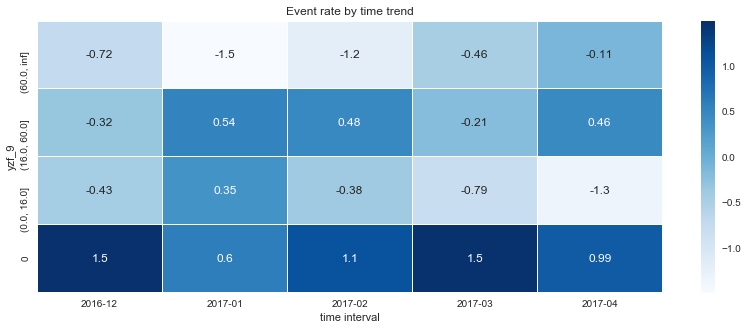

In [36]:
monthly_woe_pivot, f = pl.check_badrate_trend(X_cat_train.loc[:, the_var], y_train, month, \
                                              RESULT_PATH, normalize=True)

## 如果决定不分train，test样本

In [ ]:
monthly_woe_pivot, f = pl.check_badrate_trend(X_cat.loc[:, the_var], y, month, \
                                              RESULT_PATH, normalize=True)

# 检查变量按月分布的缺失率

在执行画图函数时图已经被存到 `result_path` 目录下的`figure/missingByTime/`路径

In [40]:
the_var = 'yzf_9'
month = data.appmonth

## 如果决定用train，test样本

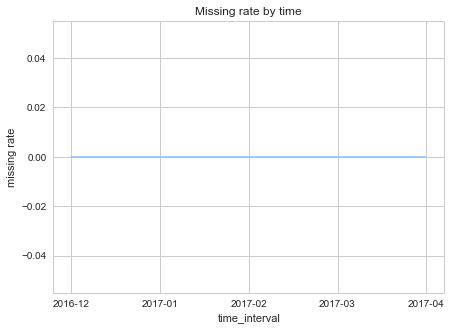

In [41]:
rates_by_month, f = pl.missing_trend(X_train.loc[:, the_var], month, RESULT_PATH)

## 如果决定不分train，test样本

In [ ]:
rates_by_month, f = pl.missing_trend(X.loc[:, the_var], month, RESULT_PATH)

In [ ]:
rates_by_month

In [ ]:
f

# 建模 & 评估

In [126]:
rebin_spec_bin_adjusted.keys()

[u'yzf_5', u'yzf_4', u'yzf_9', u'yzf_3']

In [43]:
to_keep = [
#     u'yzf_5', 
    u'yzf_4', 
    u'yzf_9', 
    u'yzf_3'
]

## 如果决定用train，test样本

### 建模

In [133]:
X_transformed_train.shape

(1426, 5)

In [134]:
y_train.shape

(1426,)

In [ ]:
# 统计训练集和测试集的划分比例
sample_split_summary = ss.sample_split_summary(y_train,y_test)

In [44]:
model_final, p_train, p_test = fs.FeatureSelection().logistic_regression(X_transformed_train[to_keep],\
                                                                           X_transformed_test[to_keep],\
                                                                           y_train)

In [45]:
# 训练集统计结果
train_stat = fs.FeatureSelection().model_stat_result(model_final,var_dict)
train_stat

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1426
Model:                            GLM   Df Residuals:                     1422
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -608.59
Date:                Tue, 21 Nov 2017   Deviance:                       1217.2
Time:                        13:53:05   Pearson chi2:                 1.43e+03
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6421      0.075    -21.974      0.000      -1.789      -1.496
yzf_4          0.8108      0.244      3.329      0.001       0.333       1.288
yzf_9          0.8232      0.209      3.941      0.000       0.414       1.233
yzf_3          0.8004      0.327      2.450      0.014       0.160       1.441
==============================================================================
"""

In [46]:
model_final_test, _, _ = fs.FeatureSelection().logistic_regression(X_transformed_test[to_keep],\
                                                                X_transformed_test[to_keep],\
                                                                y_test)


In [47]:
# 测试集统计结果
test_stat = fs.FeatureSelection().model_stat_result(model_final_test,var_dict)
test_stat

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                  612
Model:                            GLM   Df Residuals:                      608
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -269.07
Date:                Tue, 21 Nov 2017   Deviance:                       538.14
Time:                        13:53:14   Pearson chi2:                     617.
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5995      0.110    -14.510      0.000      -1.816      -1.383
yzf_4          0.4914      0.321      1.533      0.125      -0.137       1.120
yzf_9          0.5925      0.281      2.107      0.035       0.041       1.143
yzf_3          0.4044      0.492      0.822      0.411      -0.560       1.369
==============================================================================
"""

### KS

In [ ]:
save_label = 'withZhima'

<module 'matplotlib.pyplot' from '/Users/xiangyu/ENV/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

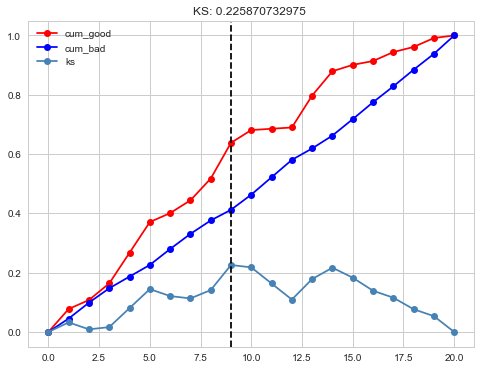

In [48]:
# Train KS
pl.ks_new(np.array(p_train), np.array(y_train), save_label='model_%s_train' % save_label, \
          plot=True, result_path=RESULT_PATH)

<module 'matplotlib.pyplot' from '/Users/xiangyu/ENV/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

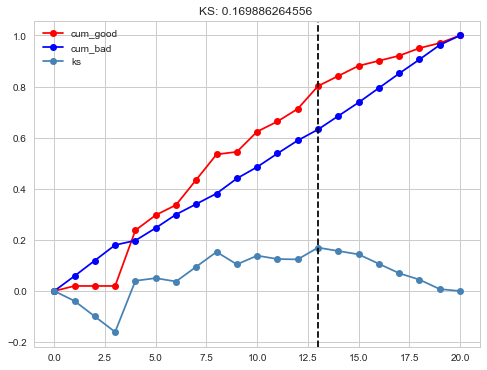

In [49]:
# Test KS
pl.ks_new(np.array(p_test), np.array(y_test), save_label='model_%s_test' % save_label, \
          plot=True, result_path=RESULT_PATH)

### AUC

(0.62984823543002366, <matplotlib.figure.Figure at 0x125e178d0>)

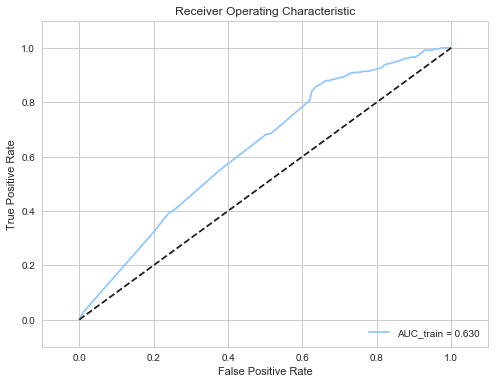

In [50]:
pl.print_AUC_one(y_train, p_train, save_label='model_%s_train' % save_label, result_path=RESULT_PATH)

(0.5908527251942417, <matplotlib.figure.Figure at 0x11b5c32d0>)

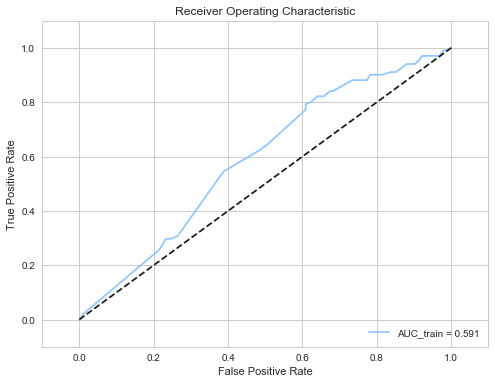

In [51]:
pl.print_AUC_one(y_test, p_test, save_label='model_%s_test' % save_label, result_path=RESULT_PATH)

In [146]:
save_data_to_pickle(model_final, RESULT_PATH, 'model_%s.pkl' % save_label)

### 选中变量correlation

In [52]:
X_transformed_train[to_keep].corr()

,yzf_4,yzf_9,yzf_3
yzf_4,1.000000,0.254088,0.120612
yzf_9,0.254088,1.000000,0.088962
yzf_3,0.120612,0.088962,1.000000


### 评分卡

In [52]:
final_model = load_data_from_pickle(RESULT_PATH, 'model_%s.pkl' % save_label)
coefficients = final_model.params.to_frame('beta').reset_index().rename(columns={'index':'var_code'})

In [53]:
coefficients

,var_code,beta
0,const,-1.641179
1,yzf_4,0.875702
2,yzf_9,0.855241
3,yzf_3,0.754064


In [55]:
woe_iv_df_coarse = pd.read_excel(os.path.join(RESULT_PATH, 'coarse_classing_woe_iv_df.xlsx'), encoding='utf-8')

In [56]:
cleaned_woe = woe_iv_df_coarse.loc[woe_iv_df_coarse[u'变量英文'].isin(coefficients.var_code), [u'变量英文', u'分箱', 'N', u'分布占比', 'WOE', u'逾期率', u'Bad分布占比']]
cleaned_woe.head()

,变量英文,分箱,N,分布占比,WOE,逾期率,Bad分布占比
0,yzf_3,"(-inf, 20.0]",127,0.089060,0.129430,0.181102,0.099138
1,yzf_3,0.0,466,0.326788,0.276002,0.203863,0.409483
2,yzf_3,"(20.0, 30.0]",111,0.077840,-0.217971,0.135135,0.064655
3,yzf_3,"(30.0, 43.0]",120,0.084151,-0.096274,0.150000,0.077586
4,yzf_3,"(43.0, 59.0]",125,0.087658,-0.019901,0.160000,0.086207


In [57]:
score_card = mt.Performance().calculate_score(coefficients, cleaned_woe, 'var_score', var_dict)

In [58]:
score_card.to_excel(os.path.join(RESULT_PATH, '%s_score_card.xlsx' % save_label), \
                    encoding='utf-8', index=False)

### 算分 & decile

In [65]:
selected = [i for i in coefficients.var_code if i != 'const']
train_score = mt.Performance().calculate_score_by_scrd(X_cat_train[selected], score_card)
test_score = mt.Performance().calculate_score_by_scrd(X_cat_test[selected], score_card)


In [66]:
ks_decile_train = mt.Performance().calculate_ks_by_decile(train_score, np.array(y_train), 'decile', q=5)
ks_decile_train

col_0,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(469.0, 526.0]",575,435,140,0.243478,0.603448,0.364322,0.603448,0.364322,0.239127,3.1
1,"(526.0, 564.0]",306,253,53,0.173203,0.228448,0.211893,0.831897,0.576214,0.255682,4.8
2,"(564.0, 655.0]",262,234,28,0.106870,0.120690,0.195980,0.952586,0.772194,0.180392,8.4
3,"(655.0, 939.0]",283,272,11,0.038869,0.047414,0.227806,1.000000,1.000000,0.000000,24.7


In [67]:
point_bounds = mt.BinWoe().obtain_boundaries(ks_decile_train[u'分箱'])['cut_boundaries']

In [68]:
ks_decile_test = mt.Performance().calculate_ks_by_decile(test_score, np.array(y_test), 'decile', \
                                                         manual_cut_bounds=point_bounds)
ks_decile_test

col_0,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 526.0]",256,205,51,0.199219,0.504950,0.401174,0.504950,0.401174,0.103776,4.0
1,"(526.0, 564.0]",117,91,26,0.222222,0.257426,0.178082,0.762376,0.579256,0.183120,3.5
2,"(564.0, 655.0]",122,110,12,0.098361,0.118812,0.215264,0.881188,0.794521,0.086668,9.2
3,"(655.0, inf]",117,105,12,0.102564,0.118812,0.205479,1.000000,1.000000,0.000000,8.8


In [69]:
ks_decile_train.to_csv(os.path.join(RESULT_PATH, '%s_ks_decile_train.csv' % save_label), encoding='gbk')
ks_decile_test.to_csv(os.path.join(RESULT_PATH, '%s_ks_decile_test.csv' % save_label), encoding='gbk')

### 分数分布

plot的同时会把图存到提供的`result_path`目录下的`figure/score_dist/`路径

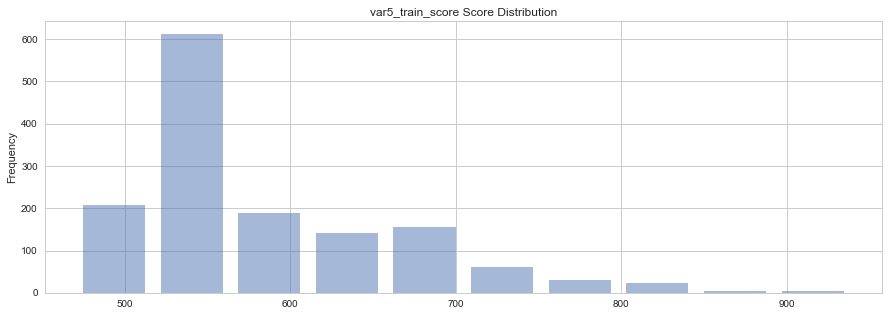

In [83]:
pl.score_dist_plot(train_score, 10, '%s_train_score' % save_label, RESULT_PATH)

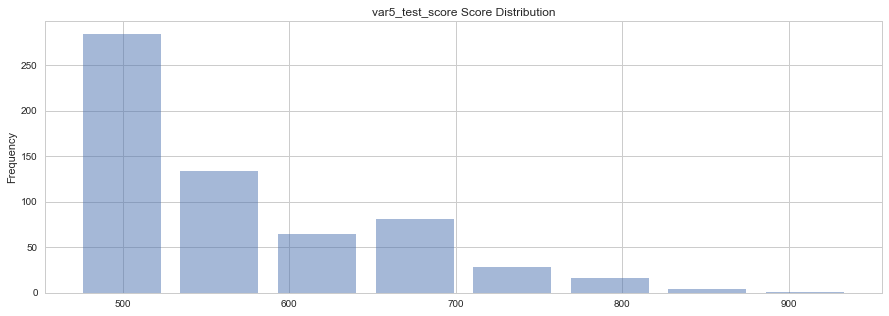

In [84]:
pl.score_dist_plot(test_score, 8, '%s_test_score' % save_label, RESULT_PATH)

In [72]:
train_score_data = train_score.to_frame('score').reset_index()\
                              .merge(data[['applyid', 'Y']], on='applyid')
train_score_data.loc[:, 'Y'] = np.where(train_score_data.Y==1, 'bad', 'good')
test_score_data = test_score.to_frame('score').reset_index()\
                      .merge(data[['applyid', 'Y']], on='applyid')
test_score_data.loc[:, 'Y'] = np.where(test_score_data.Y==1, 'bad', 'good')

In [73]:
point_bounds = mt.BinWoe().obtain_boundaries(ks_decile_train[u'分箱'])['cut_boundaries']

<module 'matplotlib.pyplot' from '/Users/xiangyu/ENV/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

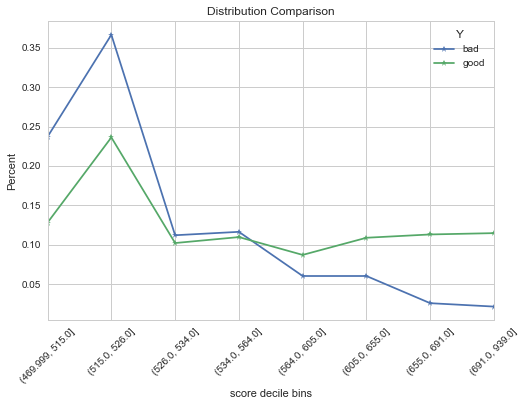

In [85]:
pl.compare_dist(train_score_data, 'score', 'Y', \
                          '%s_train_good_bad' % save_label, RESULT_PATH)

<module 'matplotlib.pyplot' from '/Users/xiangyu/ENV/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

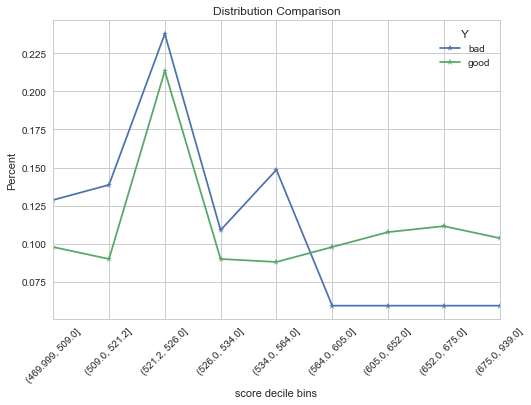

In [86]:
pl.compare_dist(test_score_data, 'score', 'Y', \
                          '%s_test_good_bad' % save_label, RESULT_PATH)

## 如果决定不分train，test样本

### 建模

In [10]:
X_transformed.shape

(2447, 14)

In [16]:
y.shape

(2447,)

In [56]:
model_final, p_train, p_train = fs.FeatureSelection().logistic_regression(X_transformed[to_keep],\
                                                                           X_transformed[to_keep],\
                                                                           y)

In [57]:
model_stat = fs.FeatureSelection().model_stat_result(model_final,var_dict)
model_stat

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                 2447
Model:                            GLM   Df Residuals:                     2441
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -315.61
Date:                Tue, 14 Nov 2017   Deviance:                       631.21
Time:                        15:12:02   Pearson chi2:                 2.56e+03
No. Iterations:                     7                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -3.3860      0.128    -26.467      0.000      -3.637      -3.135
tongdunIdMultiLoanNumPf        1.0609      0.162      6.563      0.000       0.744       1.378
ls_sales_amountSmIncrPct6M     1.4388      0.708      2.034      0.042       0.052       2.826
first_industry                 0.9146      0.333      2.749      0.006       0.262       1.567
appAmtBinByZhimaScore          1.0111      0.255      3.969      0.000       0.512       1.510
operationMonth                 1.0405      0.297      3.508      0.000       0.459       1.622
==============================================================================================
"""

In [ ]:
p_test = fs.FeatureSelection().logistic_cv(X_transformed[to_keep], y, folds=10)

### KS

In [ ]:
save_label = 'withZhima'

In [ ]:
# Train KS
pl.ks_new(np.array(p_train), np.array(y), save_label='model_%s_train' % save_label, \
          plot=True, result_path=RESULT_PATH)

In [ ]:
# Test KS
pl.ks_new(np.array(p_test), np.array(y), save_label='model_%s_test' % save_label, \
          plot=True, result_path=RESULT_PATH)

### AUC

In [ ]:
pl.print_AUC_one(y, p_train, save_label='model_%s_train' % save_label, result_path=RESULT_PATH)

In [ ]:
pl.print_AUC_one(y, p_test, save_label='model_%s_test' % save_label, result_path=RESULT_PATH)

In [ ]:
save_data_to_pickle(model_final, RESULT_PATH, 'model_%s.pkl' % save_label)

### 选中变量correlation

In [ ]:
X_transformed[to_keep].corr()

### 评分卡

In [ ]:
num_vars = 5

In [ ]:
final_model = load_data_from_pickle(RESULT_PATH, 'model_%s.pkl' % save_label)
coefficients = final_model.params.to_frame('beta').reset_index().rename(columns={'index':'var_code'})

In [ ]:
coefficients

In [ ]:
cleaned_woe = woe_iv_df_coarse.loc[woe_iv_df_coarse[u'变量英文'].isin(coefficients.var_code), [u'变量英文', u'分箱', 'N', u'分布占比', 'WOE', u'逾期率', u'Bad分布占比']]
cleaned_woe.head()

In [ ]:
score_card = mt.Performance().calculate_score(coefficients, cleaned_woe, 'var_score', var_dict)

In [ ]:
score_card.to_excel(os.path.join(RESULT_PATH, '%s_score_card.xlsx' % save_label), \
                    encoding='utf-8', index=False)

### 算分 & decile

In [ ]:
selected = [i for i in coefficients.var_code if i != 'const']
all_score = mt.Performance().calculate_score_by_scrd(X_cat[selected], score_card)


In [ ]:
ks_decile = mt.Performance().calculate_ks_by_decile(all_score, np.array(y), 'decile', q=5)
ks_decile

In [ ]:
point_bounds = mt.BinWoe().obtain_boundaries(ks_decile[u'分箱'])['cut_boundaries']

In [ ]:
ks_decile.to_csv(os.path.join(RESULT_PATH, '%s_ks_decile.csv' % save_label), encoding='gbk')

### 分数分布

plot的同时会把图存到提供的`result_path`目录下的`figure/score_dist/`路径

In [ ]:
pl.score_dist_plot(all_score, 8, savel_label='%s_score_dist' % save_label, RESULT_PATH)

In [ ]:
score_data = all_score.to_frame('score').reset_index()\
                      .merge(data[['applyid', 'Y']], on='applyid')


In [ ]:
pl.compare_dist(score_data, 'score', 'Y', \
              '%s_good_bad' % save_label, RESULT_PATH)

# 稳定性评估

## 如果决定用train，test样本

### train vs test PSI

In [14]:
reload(mt)
perf = mt.Performance()
var_psi_result = perf.variable_psi(X_cat_train, X_cat_test, var_dict)

In [15]:
var_psi_result

,数据源,变量英文,变量中文,数据类型,变量类型,分箱,基准时点_N,基准时点占比,比较时点_N,比较时点占比,PSI
0,翼支付,yzf_4,上三个自然月提现到本人银行卡平均金额,integer,原始变量,0,1004,0.704067,440,0.718954,0.001971
1,翼支付,yzf_4,上三个自然月提现到本人银行卡平均金额,integer,原始变量,"(0.0, 77.0]",142,0.099579,62,0.101307,0.001971
2,翼支付,yzf_4,上三个自然月提现到本人银行卡平均金额,integer,原始变量,"(77.0, 341.0]",139,0.097475,53,0.086601,0.001971
3,翼支付,yzf_4,上三个自然月提现到本人银行卡平均金额,integer,原始变量,"(341.0, inf]",141,0.098878,57,0.093137,0.001971
4,翼支付,yzf_9,上三个自然月添益宝利息次数,integer,原始变量,0,1038,0.727910,434,0.709150,0.003019
5,翼支付,yzf_9,上三个自然月添益宝利息次数,integer,原始变量,"(0.0, 16.0]",133,0.093268,56,0.091503,0.003019
6,翼支付,yzf_9,上三个自然月添益宝利息次数,integer,原始变量,"(16.0, 60.0]",126,0.088359,58,0.094771,0.003019
7,翼支付,yzf_9,上三个自然月添益宝利息次数,integer,原始变量,"(60.0, inf]",129,0.090463,64,0.104575,0.003019
8,翼支付,yzf_3,上三个自然月营销参与平均金额,integer,原始变量,"(-inf, 20.0]",131,0.091865,68,0.111111,0.022001
9,翼支付,yzf_3,上三个自然月营销参与平均金额,integer,原始变量,0,472,0.330996,220,0.359477,0.022001


In [72]:
score_psi_result = perf.score_psi(train_score, test_score, score_cut_bins=[-np.inf, 500, 800, 1000, np.inf])

**需要先整理数据至可以plot的情况**

In [150]:
# 整理数据
train_score = train_score.to_frame('score')
train_score.loc[:, 'group_label'] = 'train'
test_score = test_score.to_frame('score')
test_score.loc[:, 'group_label'] = 'test'

all_score_to_plot = pd.concat([train_score, test_score])
all_score_to_plot.head()

,score,group_label
applyid,,
1,632.0,train
2,521.0,train
4,493.0,train
5,805.0,train
6,505.0,train


<module 'matplotlib.pyplot' from '/Users/xiangyu/ENV/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

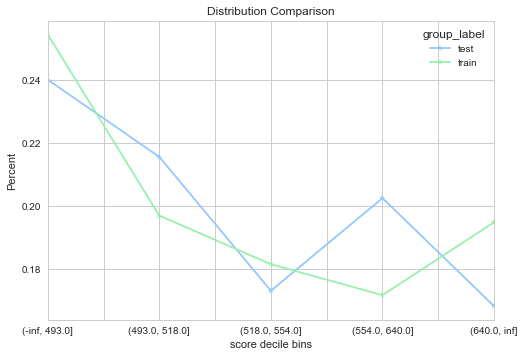

In [151]:
pl.compare_dist(all_score_to_plot, 'score', 'group_label', \
              'train_test', RESULT_PATH)

In [154]:
all_score_to_plot.loc[y[y==1].index, 'label2'] = np.where(all_score_to_plot.loc[y[y==1].index, 'group_label']=='train', 'train_bad', 'test_bad')
all_score_to_plot.loc[y[y==0].index, 'label2'] = np.where(all_score_to_plot.loc[y[y==0].index, 'group_label']=='train', 'train_good', 'test_good')

all_score_to_plot.head()

,score,group_label,label2
applyid,,,
1,632.0,train,train_bad
2,521.0,train,train_bad
4,493.0,train,train_bad
5,805.0,train,train_bad
6,505.0,train,train_bad


<module 'matplotlib.pyplot' from '/Users/xiangyu/ENV/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

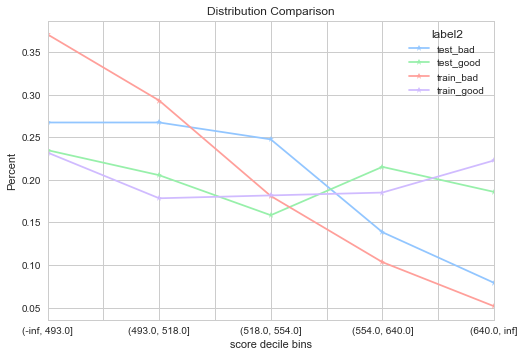

In [155]:
pl.compare_dist(all_score_to_plot, 'score', 'label2', \
              'train_test by good_bad', RESULT_PATH, \
              cut_bounds=point_bounds)


# 统计模型输出文档（暂时只有划分训练集和测试集的，无PSI版本）

## 从新存储解决编解码问题

In [ ]:
# 这部分会存在编解码问题，从新按照utf-8存储一下即可
model_result.to_excel(os.path.join(Result_path, 'stepwise_woe_iv_df.xlsx'), index=False, encoding='utf-8')
stepwise_woe_iv = pd.read_excel(os.path.join(Result_path, 'stepwise_woe_iv_df.xlsx'))

woe_iv_df_coarse.to_excel(os.path.join(Result_path, 'woe_iv_df_coarse_df.xlsx'), index=False, encoding='utf-8')
woe_iv_df_coarse = pd.read_excel(os.path.join(Result_path, 'woe_iv_df_coarse_df.xlsx'))

## 汇总所有建模结果

In [ ]:
Fig_path = u'/Users/pintec/Documents/seafile/分析文件/modeling/个贷/XJD_WK_A_V1/result/figure'
Result_path_2 = u'/Users/pintec/Desktop/'
# 评分分布的图片，list中的顺序必须是训练集的图片名，然后才是测试集的图片名称
score_dis = [u'score_dist/var6_train_nozhima_score_dist_plot.png',u'score_dist/var6_test_nozhima_score_dist_plot.png']
# KS和AUC的图片，list中的顺序必须是训练集测试集KS图片，然后才是训练集测试集AUC的图片名称，存储顺序不可改变
ks_auc = [u'KS/model_nozhima_train_KS.png',u'KS/model_nozhima_test_KS.png'\
                      ,u'AUC/model_nozhima_train_AUC.png',u'AUC/model_nozhima_test_AUC.png']

In [ ]:
# 采用OrderedDict保证生成的all_data_dict中生成的keys的顺序不会改变
import collections
all_data_dic_c = collections.OrderedDict()
all_data_dic_c[u'附2变量字典'] = var_dict
all_data_dic_c[u'附1变量进入过程'] = selection_process
# ks_decile_train,ks_decile_test,run_book三者顺序不能变
all_data_dic_c[u'S3.7决策参考'] = [ks_decile_train,ks_decile_test,run_book]
all_data_dic_c[u'S3.6评分卡'] = score_card
# sample_split_summary,train_stat,test_stat,corr四者顺序不能变
all_data_dic_c[u'S3.5模型结果'] = [sample_split_summary,train_stat\
                               ,test_stat,corr]
all_data_dic_c[u'S3.4变量粗分箱'] = woe_iv_df_coarse
all_data_dic_c[u'S3.3变量细分箱'] = stepwise_woe_iv
all_data_dic_c[u'S3.2变量重要性排序'] = ranking_result
all_data_dic_c[u'S3.1变量描述性统计'] = summary

## 汇总所有的结果

In [ ]:
ss.XlModelSummary(Result_path_2,Fig_path,u'test.xlsx',all_data_dic_c,score_dis,ks_auc).run()

# Back test/Out-of-sample/Indeterminate 

**假设新进来的X数据是`back_X`, 且`index`为`applyid`或其他unique identifier**

## 打分

In [ ]:
var_dict = var_dict = pd.read_excel(os.path.join(DATA_PATH, '外部数据变量字典20171024-翼支付.xlsx'), \
                         encoding='utf-8', sheetname='变量字典')

rebin_spec_bin_adjusted = load_data_from_pickle(RESULT_PATH, 'selected_coarse_rebin_spec.pkl')
woe_iv_df_coarse = pd.read_excel(os.path.join(RESULT_PATH, 'coarse_classing_woe_iv_df.xlsx'), encoding='utf-8')

final_model = load_data_from_pickle(RESULT_PATH, 'model_5vars.pkl')
coefficients = final_model.params.to_frame('beta').reset_index().rename(columns={'index':'var_code'})
score_card = pd.read_excel(os.path.join(RESULT_PATH, 'var5_score_card.xlsx'), \
                    encoding='utf-8')

In [ ]:
back_X = mu.process_missing(back_X, var_dict, known_missing={-9999999: -8887})

In [ ]:
bin_obj = mt.BinWoe()
back_X_cat = bin_obj.convert_to_category(back_X, var_dict, rebin_spec_bin_adjusted)
back_X_transformed = bin_obj.transform_x_all(back_X_cat, woe_iv_df_coarse)

In [ ]:
selected = [i for i in coefficients.var_code if i != 'const']
back_score = mt.Performance().calculate_score_by_scrd(back_X_cat[selected], score_card)


## PSI

### 如果建模时有用train，test样本

In [ ]:
perf = mt.Performance()
var_psi_result = perf.variable_psi(X_cat_train, back_X_cat, var_dict)

In [ ]:
score_psi_result = perf.score_psi(train_score, back_score, score_cut_bins=[-np.inf, 100, 200, np.inf])

In [150]:
# 整理数据
train_score = train_score.to_frame('score')
train_score.loc[:, 'group_label'] = 'train'
back_score = back_score.to_frame('score')
back_score.loc[:, 'group_label'] = 'back'

all_score_to_plot = pd.concat([train_score, back_score])
all_score_to_plot.head()

,score,group_label
applyid,,
1,632.0,train
2,521.0,train
4,493.0,train
5,805.0,train
6,505.0,train


<module 'matplotlib.pyplot' from '/Users/xiangyu/ENV/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

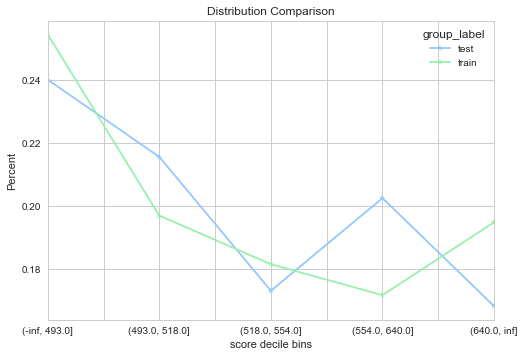

In [151]:
pl.compare_dist(all_score_to_plot, 'score', 'group_label', \
              'train_test', RESULT_PATH)

### 如果建模时没有用train，test样本

In [ ]:
perf = mt.Performance()
var_psi_result = perf.variable_psi(X_cat, back_X_cat, var_dict)

In [ ]:
score_psi_result = perf.score_psi(all_score, back_score, score_cut_bins=[-np.inf, 100, 200, np.inf])

In [150]:
# 整理数据
all_score = all_score.to_frame('score')
all_score.loc[:, 'group_label'] = 'train'
back_score = back_score.to_frame('score')
back_score.loc[:, 'group_label'] = 'back'

all_score_to_plot = pd.concat([all_score, back_score])
all_score_to_plot.head()

,score,group_label
applyid,,
1,632.0,train
2,521.0,train
4,493.0,train
5,805.0,train
6,505.0,train


<module 'matplotlib.pyplot' from '/Users/xiangyu/ENV/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

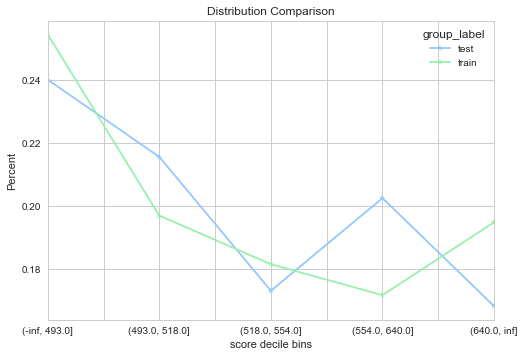

In [151]:
pl.compare_dist(all_score_to_plot, 'score', 'group_label', \
              'train_test', RESULT_PATH)

## 分数分布

In [ ]:
pl.score_dist_plot(back_score, 10, savel_label='var5_back_score', RESULT_PATH)

# Reject Inference

给已经拒绝的样本/样本外样本/indeterminate样本打分，对比其分数分布。和建模样本的分布对比，与建模样本中好客户的分数分布对比，坏客户的分数分布对比。


**假设拒绝样本的X变量为`reject_X`, 且`index`为`applyid`或其他unique identifier**

## 打分

In [ ]:
var_dict = var_dict = pd.read_excel(os.path.join(DATA_PATH, '外部数据变量字典20171024-翼支付.xlsx'), \
                         encoding='utf-8', sheetname='变量字典')

rebin_spec_bin_adjusted = load_data_from_pickle(RESULT_PATH, 'selected_coarse_rebin_spec.pkl')
woe_iv_df_coarse = pd.read_excel(os.path.join(RESULT_PATH, 'coarse_classing_woe_iv_df.xlsx'), encoding='utf-8')

final_model = load_data_from_pickle(RESULT_PATH, 'model_5vars.pkl')
coefficients = final_model.params.to_frame('beta').reset_index().rename(columns={'index':'var_code'})
score_card = pd.read_excel(os.path.join(RESULT_PATH, 'var5_score_card.xlsx'), \
                    encoding='utf-8')

In [ ]:
reject_X = mu.process_missing(reject_X, var_dict, known_missing={-9999999: -8887})

In [ ]:
bin_obj = mt.BinWoe()
reject_X_cat = bin_obj.convert_to_category(reject_X, var_dict, rebin_spec_bin_adjusted)
reject_X_transformed = bin_obj.transform_x_all(reject_X_cat, woe_iv_df_coarse)

In [ ]:
selected = [i for i in coefficients.var_code if i != 'const']
reject_score = mt.Performance().calculate_score_by_scrd(reject_X_cat[selected], score_card)


In [ ]:
reject_score = reject_score.to_frame('score').reset_index()
reject_score.loc[:, 'Y'] = 'reject'

## 分数分布对比


### 如果建模时有用train，test样本

In [ ]:
train_score_data = train_score.to_frame('score').reset_index()\
                              .merge(data[['applyid', 'Y']], on='applyid')
train_score_data.loc[:, 'Y'] = np.where(train_score_data.Y==1, 'bad', 'good')

plot_score_data = pd.concat([reject_score, train_score_data])

In [ ]:
pl.compare_dist(plot_score_data, 'score', 'Y', \
              'train_test', RESULT_PATH)

### 如果建模时没有用train，test样本

In [ ]:
score_data = all_score.to_frame('score').reset_index()\
                      .merge(data[['applyid', 'Y']], on='applyid')

plot_score_data = pd.concat([reject_score, score_data])

In [ ]:
pl.compare_dist(plot_score_data, 'score', 'Y', \
              'train_test', RESULT_PATH)

# 全样本结果输出写入数据库

## 如果建模时有用train，test样本

In [ ]:
X_cat_train = load_data_from_pickle(PATH, 'X_cat_train.pkl')
X_cat_test = load_data_from_pickle(PATH, 'X_cat_test.pkl')
X_cat = pd.concat([X_cat_train, X_cat_test])

## 如果建模时没有用train，test样本

In [ ]:
X_cat = load_data_from_pickle(PATH, 'X_cat.pkl')

----------------- 分割线，以下为通用部分 -----------------

In [ ]:
score_card = pd.read_excel(os.path.join(RESULT_PATH, 'var5_score_card.xlsx'), encoding='utf-8')

In [ ]:
selected = score_card[[u'变量英文']].unique()
all_score = mt.Performance().calculate_score2(X_cat[selected], score_card)

all_score = all_score.to_frame('score').reset_index()
# data_with_y: 为包含申请时点信息的表格。all_with_y为包含所有原始X数据的。应该处理过缺失值的
score_output = data_with_y[['apply_id', 'projectid', 'applicationdate', 'drawdownstamp', 'Y']]\
                    .merge(all_with_y[selected].reset_index(), on='apply_id')\
                    .merge(all_score, on='apply_id')

**以下仅为示例，请勿直接照搬**

In [ ]:
# 将此段SQL在DBeaver里执行更快捷方便，这里留存只为做记录用。
# 表名规范： tmp_{name_pinyin_initial}_{table_name}
SQL_CREATE_TABLE = """
CREATE TABLE IF NOT EXISTS hive_pro.hdp_data_sd.tmp_xx_xxxxx (
    apply_id INT,
    projectid INT,
    applicationdate VARCHAR(255),
    drawdownstamp VARCHAR(255),
    Y INT,
    score DOUBLE,
    tongdunIdMultiLoanNumPf INT,
    ls_sales_amountSmIncrPct6M DOUBLE, 
    first_industry VARCHAR(255),
    appAmtBinByZhimaScore VARCHAR(255)
    operationMonth INT
)
"""

In [ ]:
SQL_INSERT_TEMP = """
INSERT INTO hive_pro.hdp_data_sd.tmp_xx_xxxxx
(apply_id, projectid, applicationdate, drawdownstamp, Y, score, tongdunIdMultiLoanNumPf, ls_sales_amountSmIncrPct6M, first_industry, appAmtBinByZhimaScore, operationMonth)
values
{% for i in var_list %}
{{ i }},
{% endfor %}
"""

In [ ]:
var_list = []
for index, row in score_output.iterrows():
        t = "({apply_id}, {projectid}, '{applicationdate}', '{drawdownstamp}', {Y}, {score}, {tongdunIdMultiLoanNumPf}, \
            {ls_sales_amountSmIncrPct6M}, '{first_industry}', '{appAmtBinByZhimaScore}', {operationMonth})"
        t2 = t.format(apply_id = int(row['apply_id']),\
                      projectid = int(row['projectid']),\
                      applicationdate = str(row['applicationdate']),\
                      drawdownstamp = str(row['drawdownstamp']),\
                      Y = int(row['Y']),\
                      score = float(row['score']),\
                      tongdunIdMultiLoanNumPf = int(row['tongdunIdMultiLoanNumPf']),\
                      ls_sales_amountSmIncrPct6M = float(row['ls_sales_amountSmIncrPct6M']),\
                      first_industry = str(row['first_industry']),\
                      appAmtBinByZhimaScore = str(row['appAmtBinByZhimaScore']),\
                      operationMonth = int(row['operationMonth']))
        var_list.append(t2)



In [ ]:
# insert var_list to table
insert_sql = Template(SQL_INSERT_TEMP).render(var_list=var_list)
print insert_sql

In [ ]:
presto_upload_data(insert_sql[:-2])

In [ ]:
score_output.to_excel(os.path.join(RESULT_PATH, 'var5_xAndScore.xlsx'), index=False, encoding='utf-8')

# 变量进入过程

In [ ]:
summary = pd.read_excel(os.path.join(PATH, 'all_variables_summary.xlsx'), encoding='utf-8')
model_result = pd.read_excel(os.path.join(RESULT_PATH, 'stepwise_woe_iv_df.xlsx'), encoding='utf-8')
ranking_result = pd.read_excel(os.path.join(RESULT_PATH, 'overall_ranking_result.xlsx'), encoding='utf-8')

n=100
top_n = ranking_result.sort_values('overall_rank')[u'变量英文'].iloc[:n].tolist()
exclusion = ['hd_callsSource', 'hd_Call_DownFlag', 'hd_applyCity', 'applyMonths', 'hd_onlineDuration_v2',\
            'hd_operatorCity', 'hd_topOneCity', 'Zixin_DownFlag']
start_from = ['zhimaScore', 'tongdun6MIdSumLoanNumPf', 'shop_type']
# 通过综合排序选中的
selected = list(set(top_n) - set(exclusion))


In [ ]:
selection_process = summary.loc[:, [u'变量英文', u'变量中文','exclusion_reason']]

selection_process.loc[:, 'kept_after_EDA'] = np.where(selection_process.exclusion_reason.notnull(), 0, 1)
selection_process.loc[:, 'kept_after_ranking'] = np.where(selection_process[u'变量英文'].isin(selected), 1, 0)

kept2 = list(model_result.loc[model_result.FORWARD_AIC_rank.notnull(), u'变量英文'].unique()) + ['zhimaScore', 'tongdun6MIdSumLoanNumPf', 'shop_type']
selection_process.loc[:, 'kept_after_stepwise_and_correlation'] = np.where(selection_process[u'变量英文'].isin(kept2), 1, 0)

final_selected = [i for i in coefficients.var_code if i != 'const']

selection_process.loc[:, 'final_selected'] = np.where(selection_process[u'变量英文'].isin(final_selected), 1, 0)

In [ ]:
selection_process.rename(columns = {'exclusion_reason': 'EDA后去掉的原因',\
                                    'kept_after_EDA': 'EDA后保留',\
                                    'kept_after_ranking': '综合排序后保留',\
                                    'kept_after_stepwise_and_correlation': 'Stepwise和共线性处理后保留',\
                                    'final_selected': '最终模型保留'
                                   }, inplace=True)

In [ ]:
# double check
selection_process.loc[selection_process['最终模型保留'] == 1]

In [ ]:
selection_process.to_excel(os.path.join(RESULT_PATH, 'selection_process_table.xlsx'), index=False, encoding='utf-8')

# 部署

`model_label`为标注这个模型的简称，此步骤根据评分卡和分箱定义生成部署需要的2个json文档。这两个文档发给部署人员（胡湘雨 as of 2017/11/20)用于模型部署

In [ ]:
rebin_spec = load_data_from_pickle(RESULT_PATH, 'selected_coarse_rebin_spec.pkl')
var_dict = pd.read_excel(os.path.join(DATA_PATH, '流水贷建模代码可直接用变量字典.xlsx'), encoding='utf-8')
scorecard = pd.read_excel(os.path.join(RESULT_PATH, 'var5_score_card.xlsx'), encoding='utf-8')
selected = score_card[[u'变量英文']].unique()

In [ ]:
rebin_spec_json = mu.process_rebin_spec(rebin_spec, var_dict, selected)

In [ ]:
bin_to_score_json = mu.process_bin_to_score(scorecard.rename(columns={u'变量英文': u'中间层指标名称'}))

In [ ]:
save_data_to_json(rebin_spec_json, RESULT_PATH, '%s_selected_rebin_spec.json' % model_label)

In [ ]:
save_data_to_json(bin_to_score_json, RESULT_PATH, '%s_bin_to_score.json' % model_label)